In [359]:
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp
from parametres import Paras
from utilities import *
from initialisation import *
from odes import odes_scale_size
import matplotlib.pyplot as plt
from size_scaled_func import *
import datetime as dt
from simulation_func import *
import pandas as pd
import pickle as pkl
import os
import seaborn as sns
import scipy.stats as stats
import networkx as nx

# Loading Data

- Load data from `Data` 

In [150]:
base_dir = '..\Data'
sample_number = 1
type = '\eqAsb'
t_type = '_t.npy'
Para_type ='_Para.pkl'
Rt_type = '_Rt.npy'
Ct_type = '_Ct.npy'
id_type = 'speciesID.npy'
file_name = f'\eqAbl_{sample_number}'

In [250]:
base_dir = '..\Data'
sample_number = 1
type = '\Asb'
t_type = '_t.npy'
Para_type ='_Para.pkl'
Rt_type = '_Rt.npy'
Ct_type = '_Ct.npy'
id_type = 'speciesID.npy'
file_name = f'\Abl_{sample_number}'

In [258]:
# start loading
repr_t = np.load(base_dir + type + file_name + file_name + t_type)
repr_Rt = np.load(base_dir + type + file_name + file_name + Rt_type)
repr_Ct = np.load(base_dir + type + file_name + file_name + Ct_type)
para = pkl.load(open(base_dir + type + file_name + file_name + Para_type, 'rb'))
# idx = np.load(base_dir + type + file_name + file_name + id_type)

# Visualise population trajectories

- Starts with absolute biomass
- Then Abundance

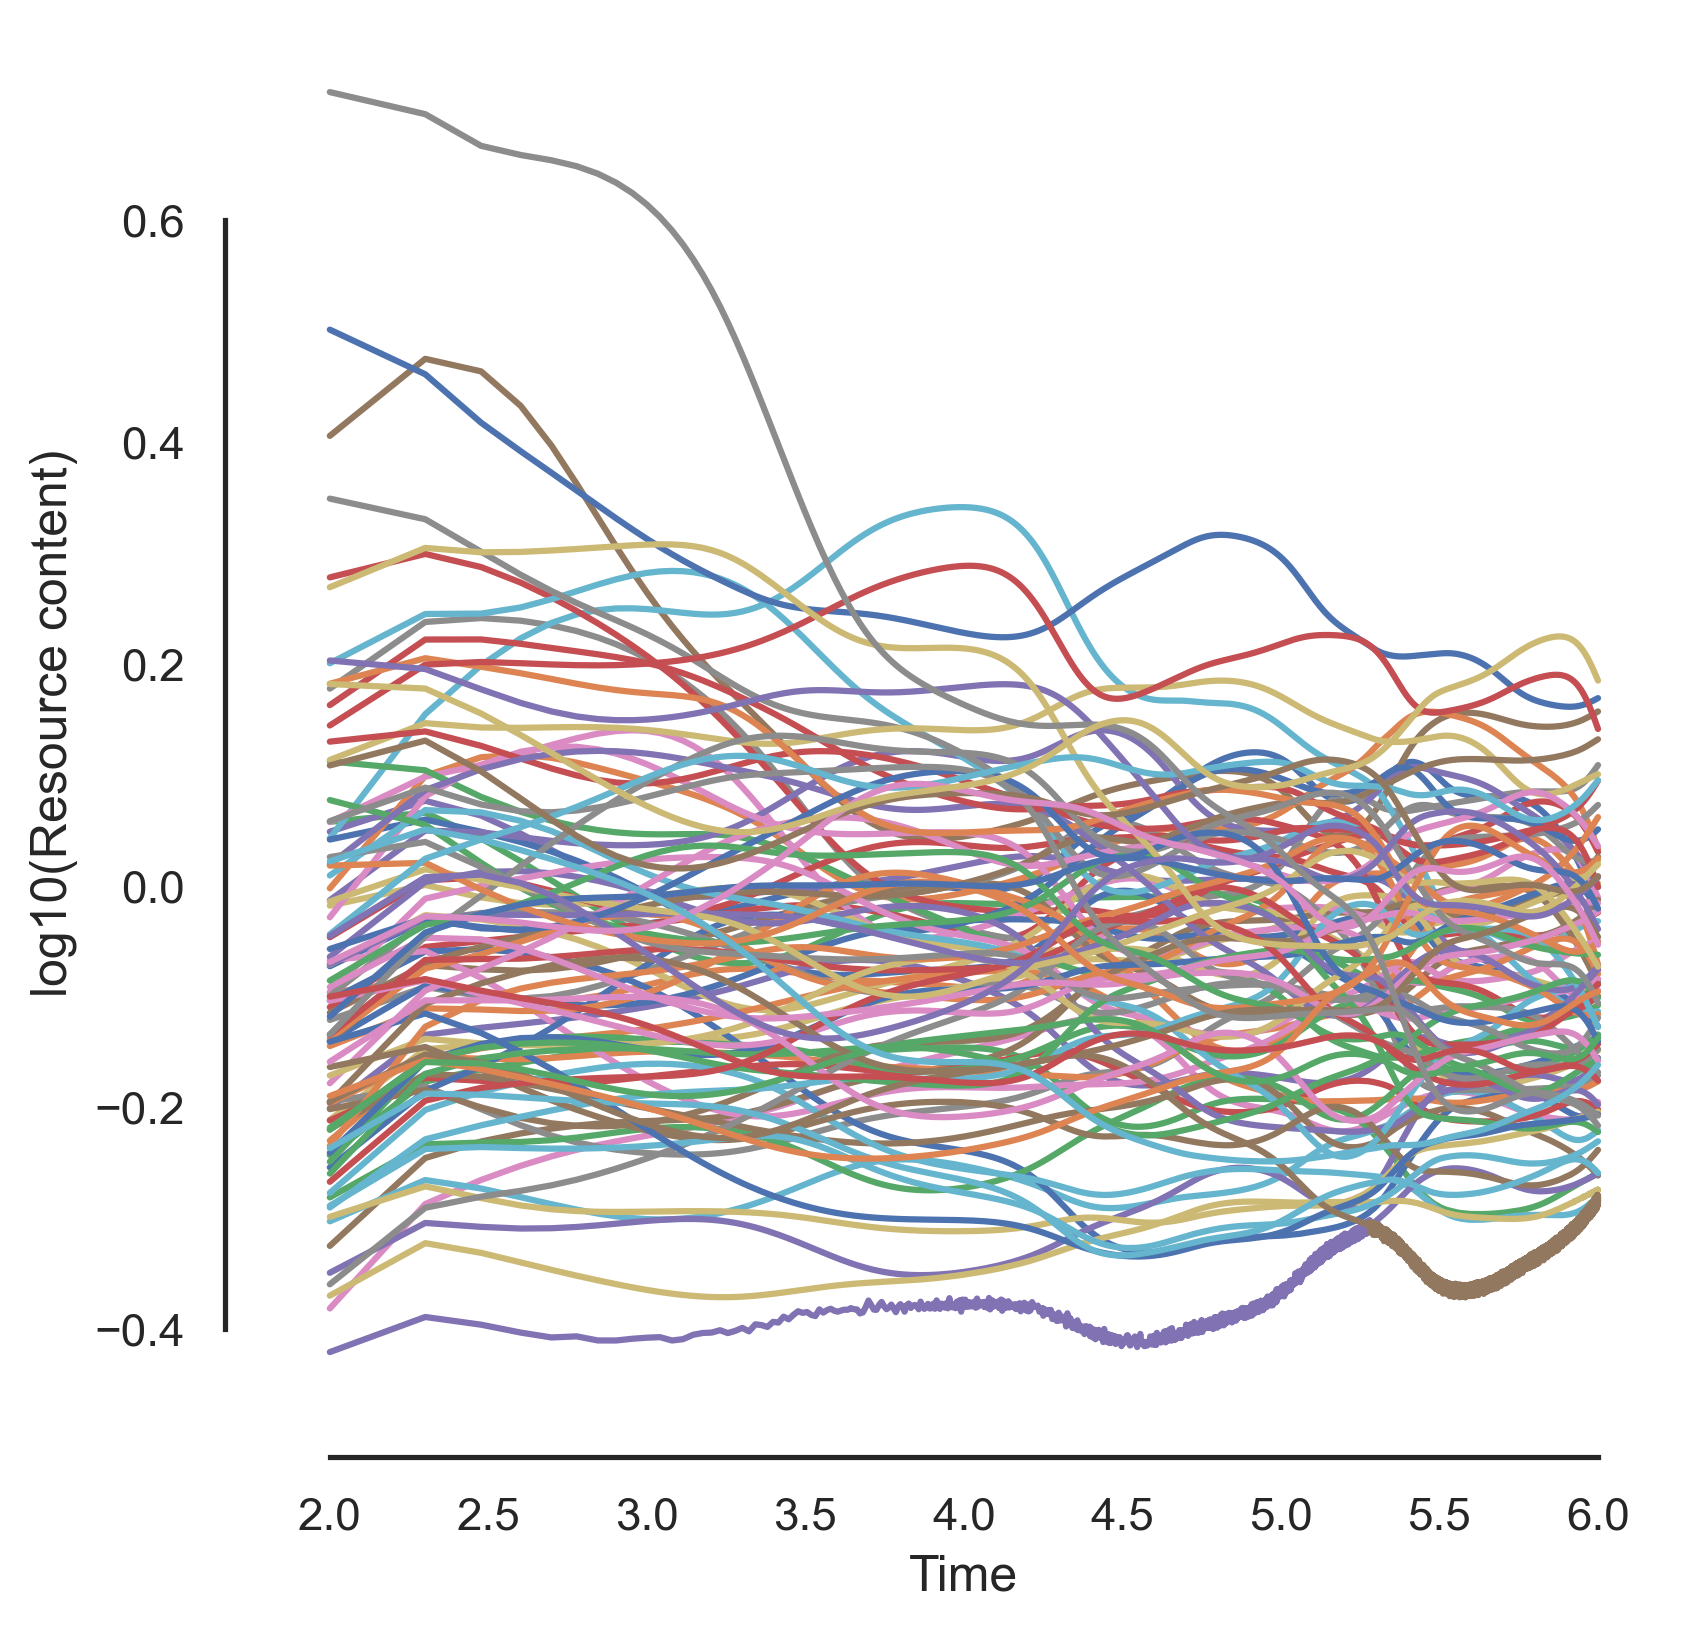

In [252]:
# plot species biomass trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.M):
    sns.lineplot(x=np.log10(repr_t), y=np.log10(repr_Rt[i, :]))
plt.xlabel('Time')
plt.ylabel('log10(Resource content)')
sns.despine(offset=10, trim=True)

Number of Species is 100
Number of resource is 100


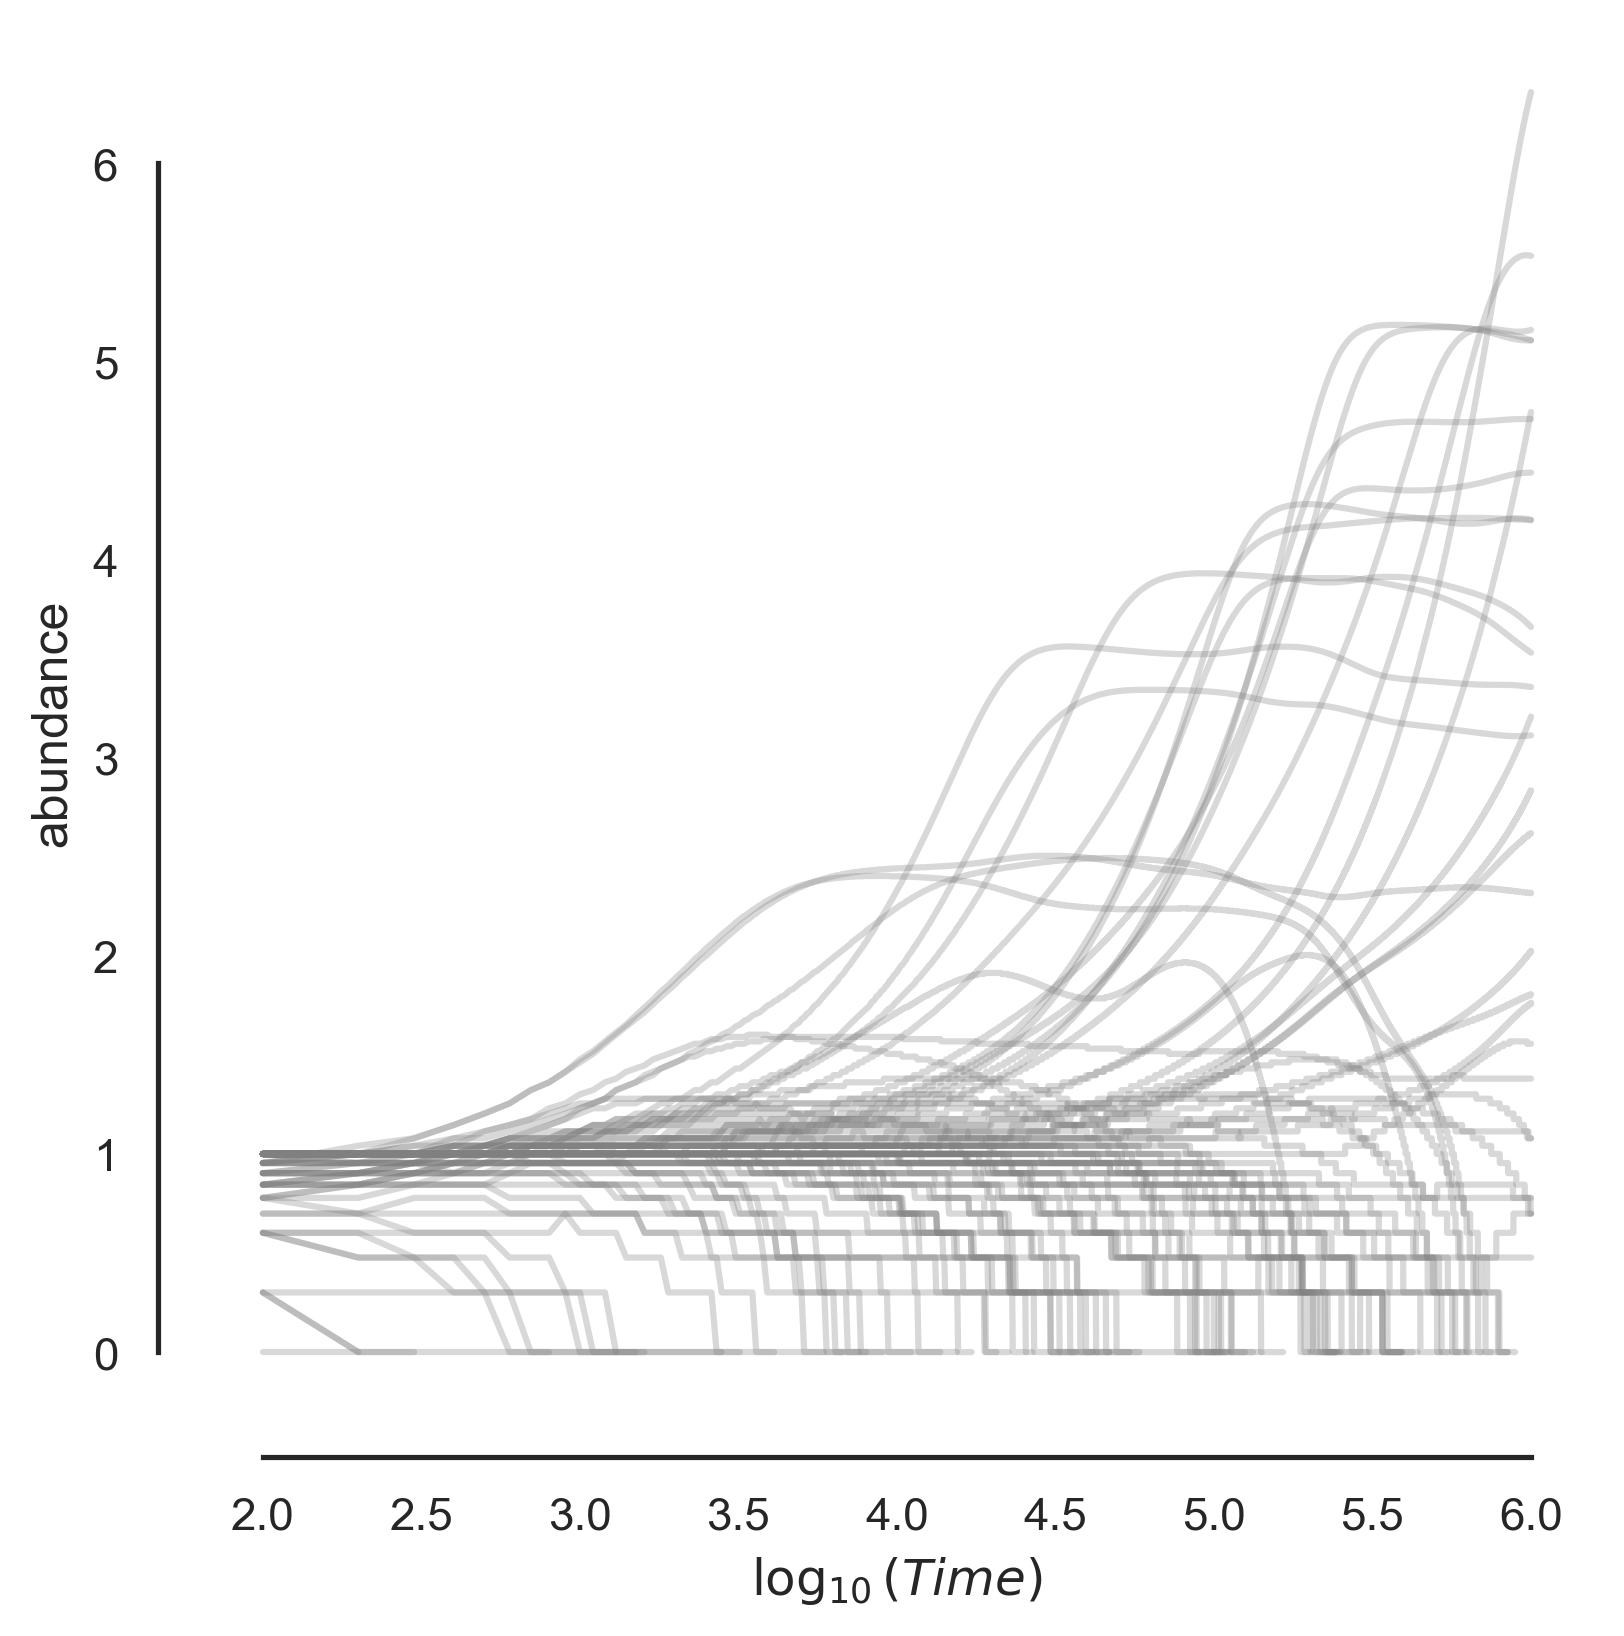

In [259]:
# get average mass
avgm = para.avgm.reshape(para.avgm.shape[0])

# calulate abundance
for j in range(len(repr_Ct[1, :])):
    repr_Ct[:, j] = repr_Ct[:, j]/avgm

# if abundance smaller than 1 then the species extincts
for i in range(len(repr_Ct[:, 1])):
    temp = repr_Ct[i, :]
    temp[temp < 1] = 0
    repr_Ct[i, :] = np.rint(temp)

# plot species biomass trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.N):
    sns.lineplot(x=np.log10(repr_t), y=np.log10(repr_Ct[i, :]), color='grey', alpha=0.3)
plt.xlabel('$\log_{10} ({Time})$')
plt.ylabel('abundance')
sns.despine(offset=10, trim=True)
print(f'Number of Species is {para.N}')
print(f'Number of resource is {para.M}')

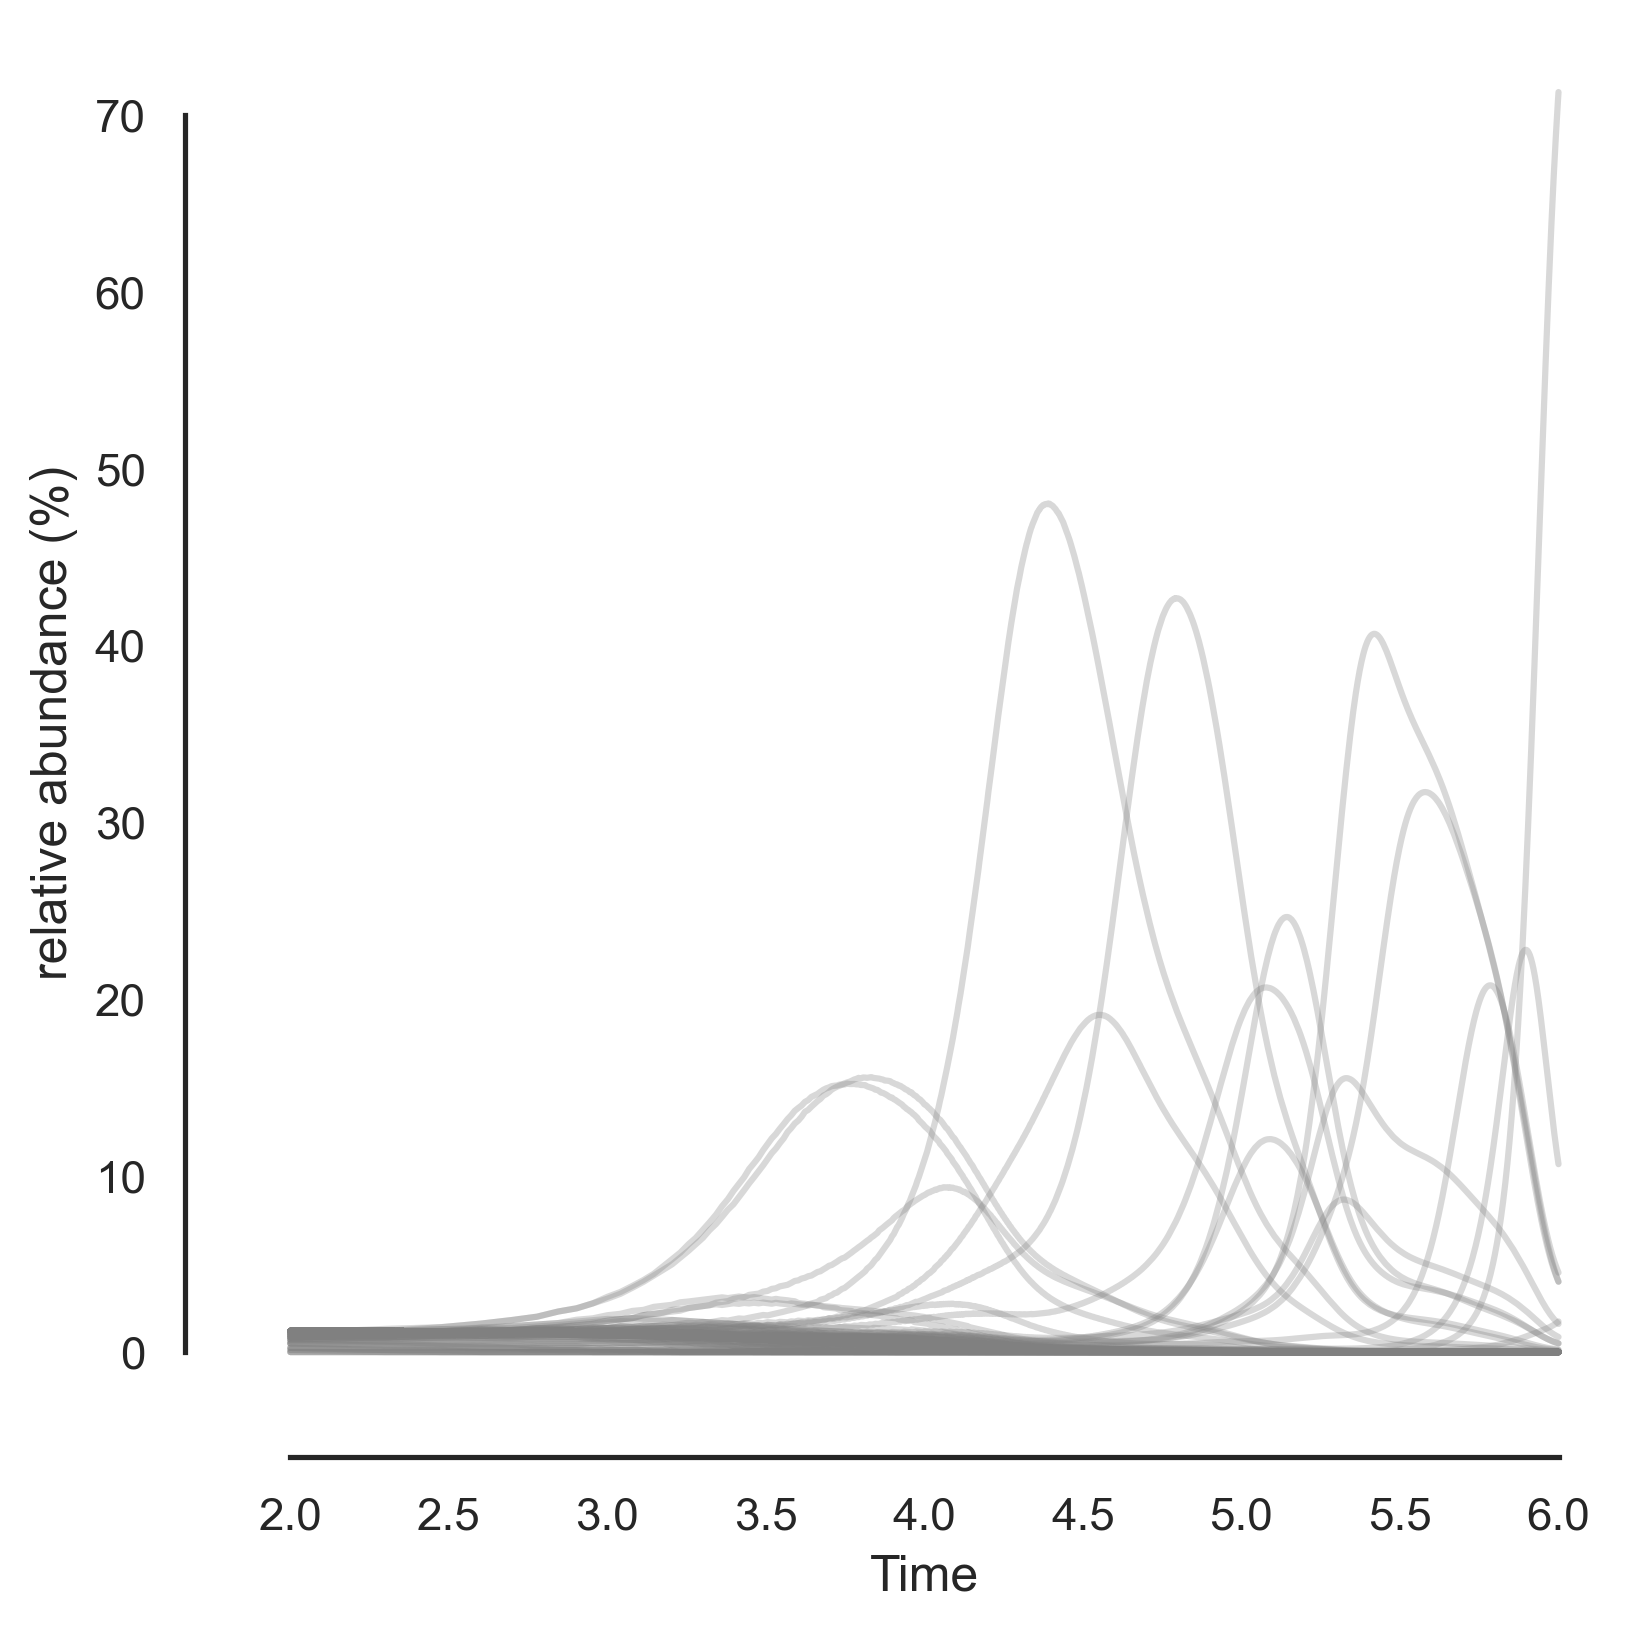

In [260]:
# plot species abudance trajectories
np.seterr(divide = 'ignore')
plt.figure(figsize=(6, 6), dpi=300)
for i in range(para.N):
    sns.lineplot(x=np.log10(repr_t), y=relative_abundance(repr_Ct)[i, :]*100,color='grey', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('relative abundance (%)')
sns.despine(offset=10, trim=True)

In [195]:
repr_Ct.shape

(100, 10000)

In [261]:
logmass = np.log10(avgm)

In [262]:
data_final= []
data_initial = []
for i in range(len(repr_Ct[:, 1])):
    freqf = round(repr_Ct[i, -1], None)
    freqi = round(repr_Ct[i, 0], None)
    data_final.append([logmass[i]]*freqf)
    data_initial.append([logmass[i]*freqi])

from functools import reduce
data_final = reduce(lambda x,y: x+y, data_final)
data_initial = reduce(lambda x,y: x+y, data_initial)


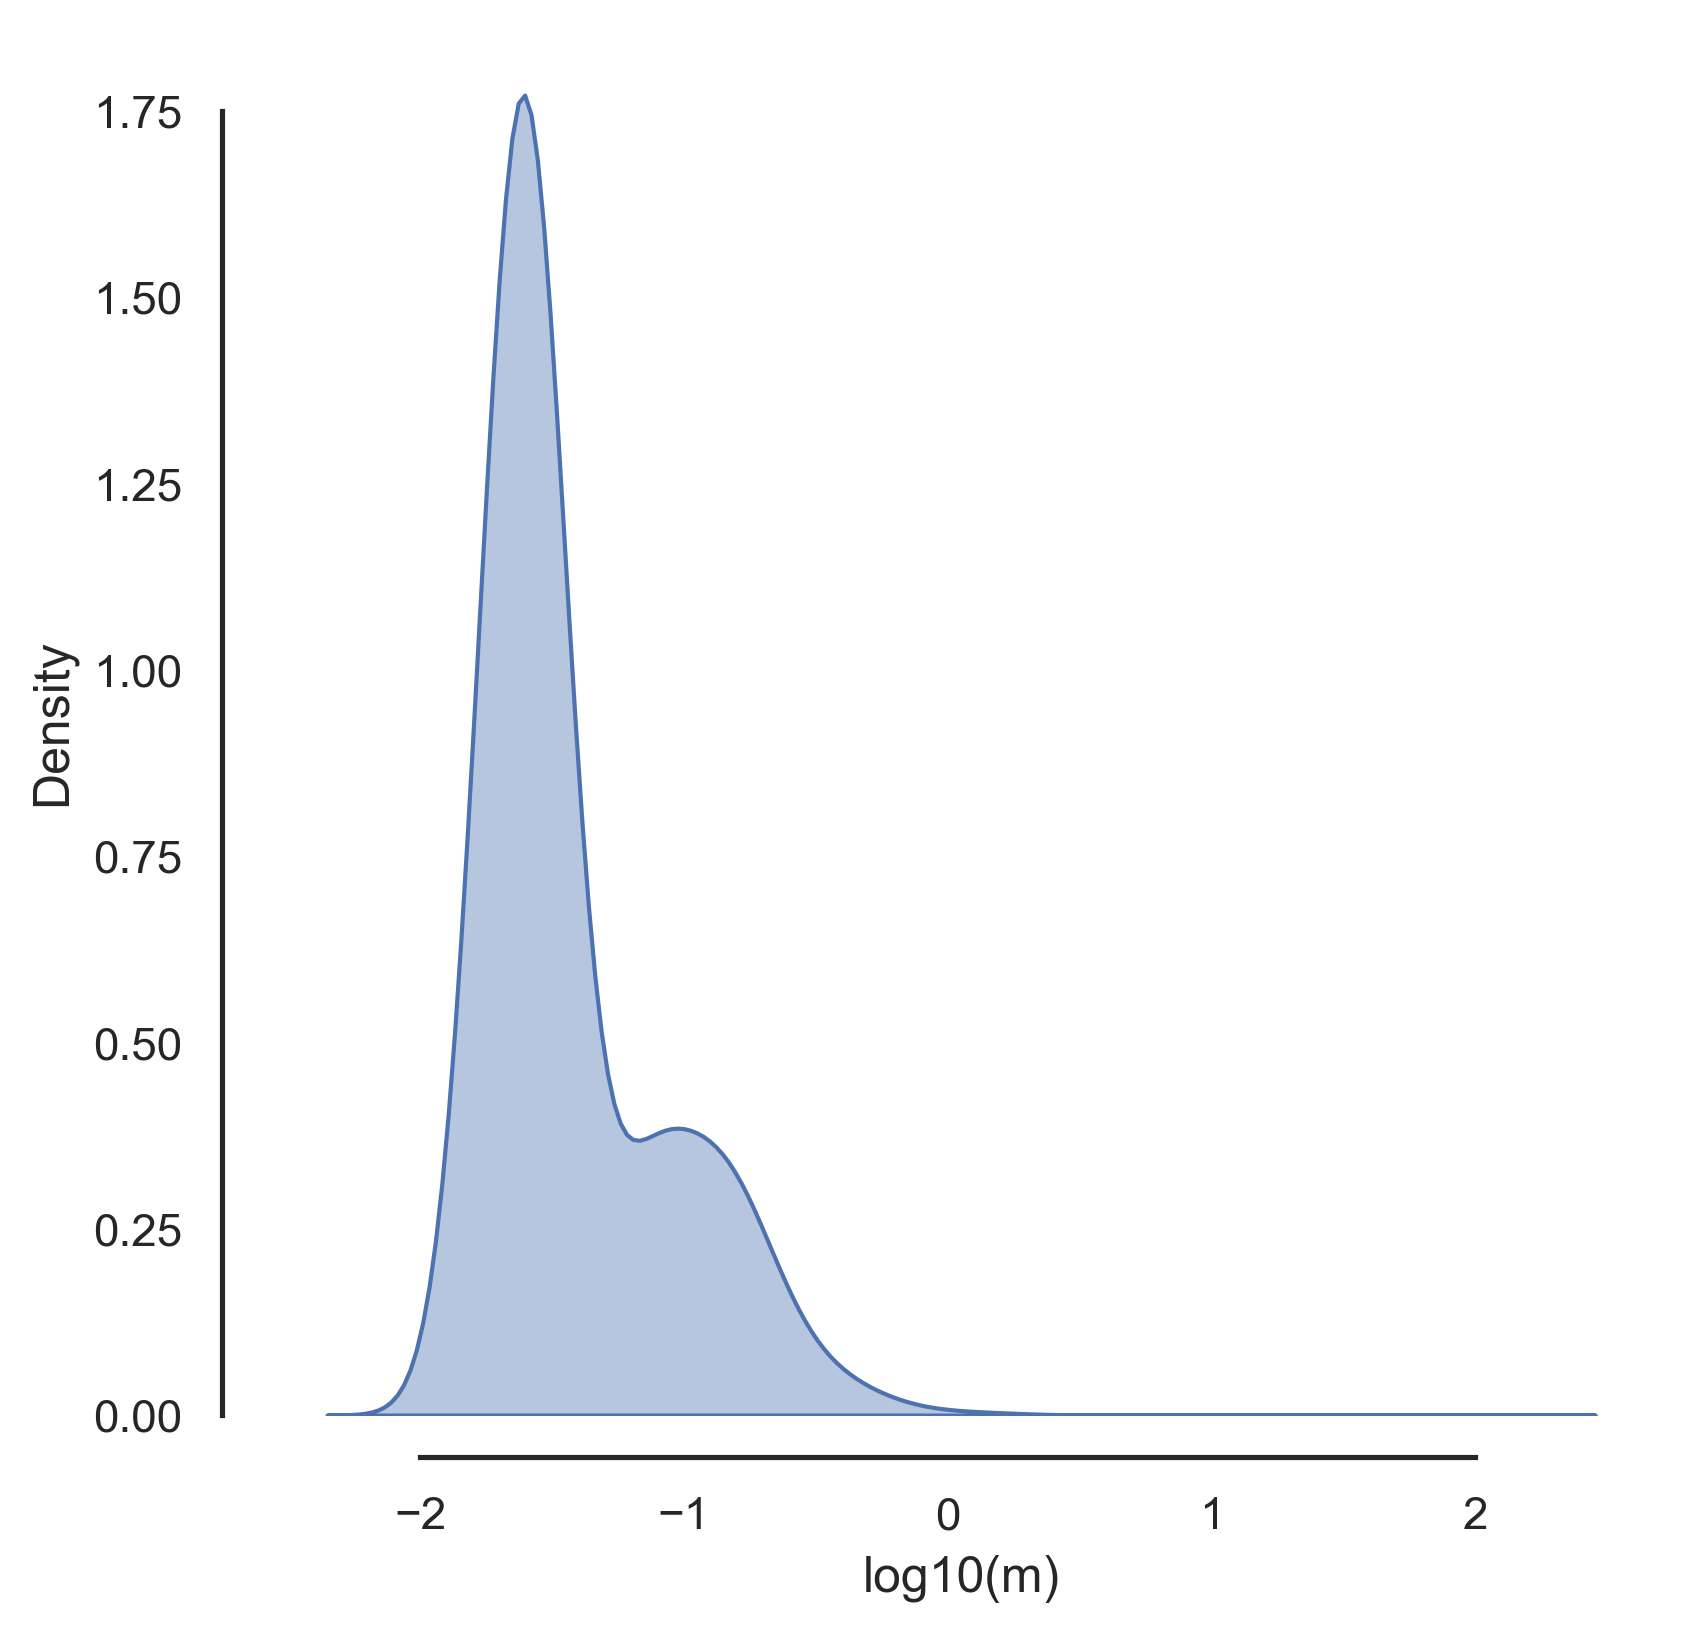

In [263]:
plt.figure(figsize=(6, 6), dpi=300)
sns.kdeplot(data_final, fill='red', alpha=0.4, bw_adjust=10)
# sns.kdeplot(data_initial, fill='grey', alpha=0.4)
# plt.legend()
plt.xlabel('log10(m)')
plt.xticks(rotation=45)
sns.despine(offset=10, trim=True)

# Species Sorting

In [264]:
print(repr_Ct.shape)
repr_Ct = (repr_Ct/np.sum(repr_Ct, 0))*100
repr_Ct[repr_Ct<1e-2] = 0

(100, 10000)


In [266]:
species_sorting = np.empty(repr_Ct.shape[1])
time = np.arange(repr_Ct.shape[1])
for i in range(repr_Ct.shape[1]):
    abdt = repr_Ct[:, i]
    num = len(abdt[abdt>0])
    species_sorting[i] = round(num)

In [267]:
species_sorting

array([100.,  97.,  96., ...,  17.,  17.,  17.])

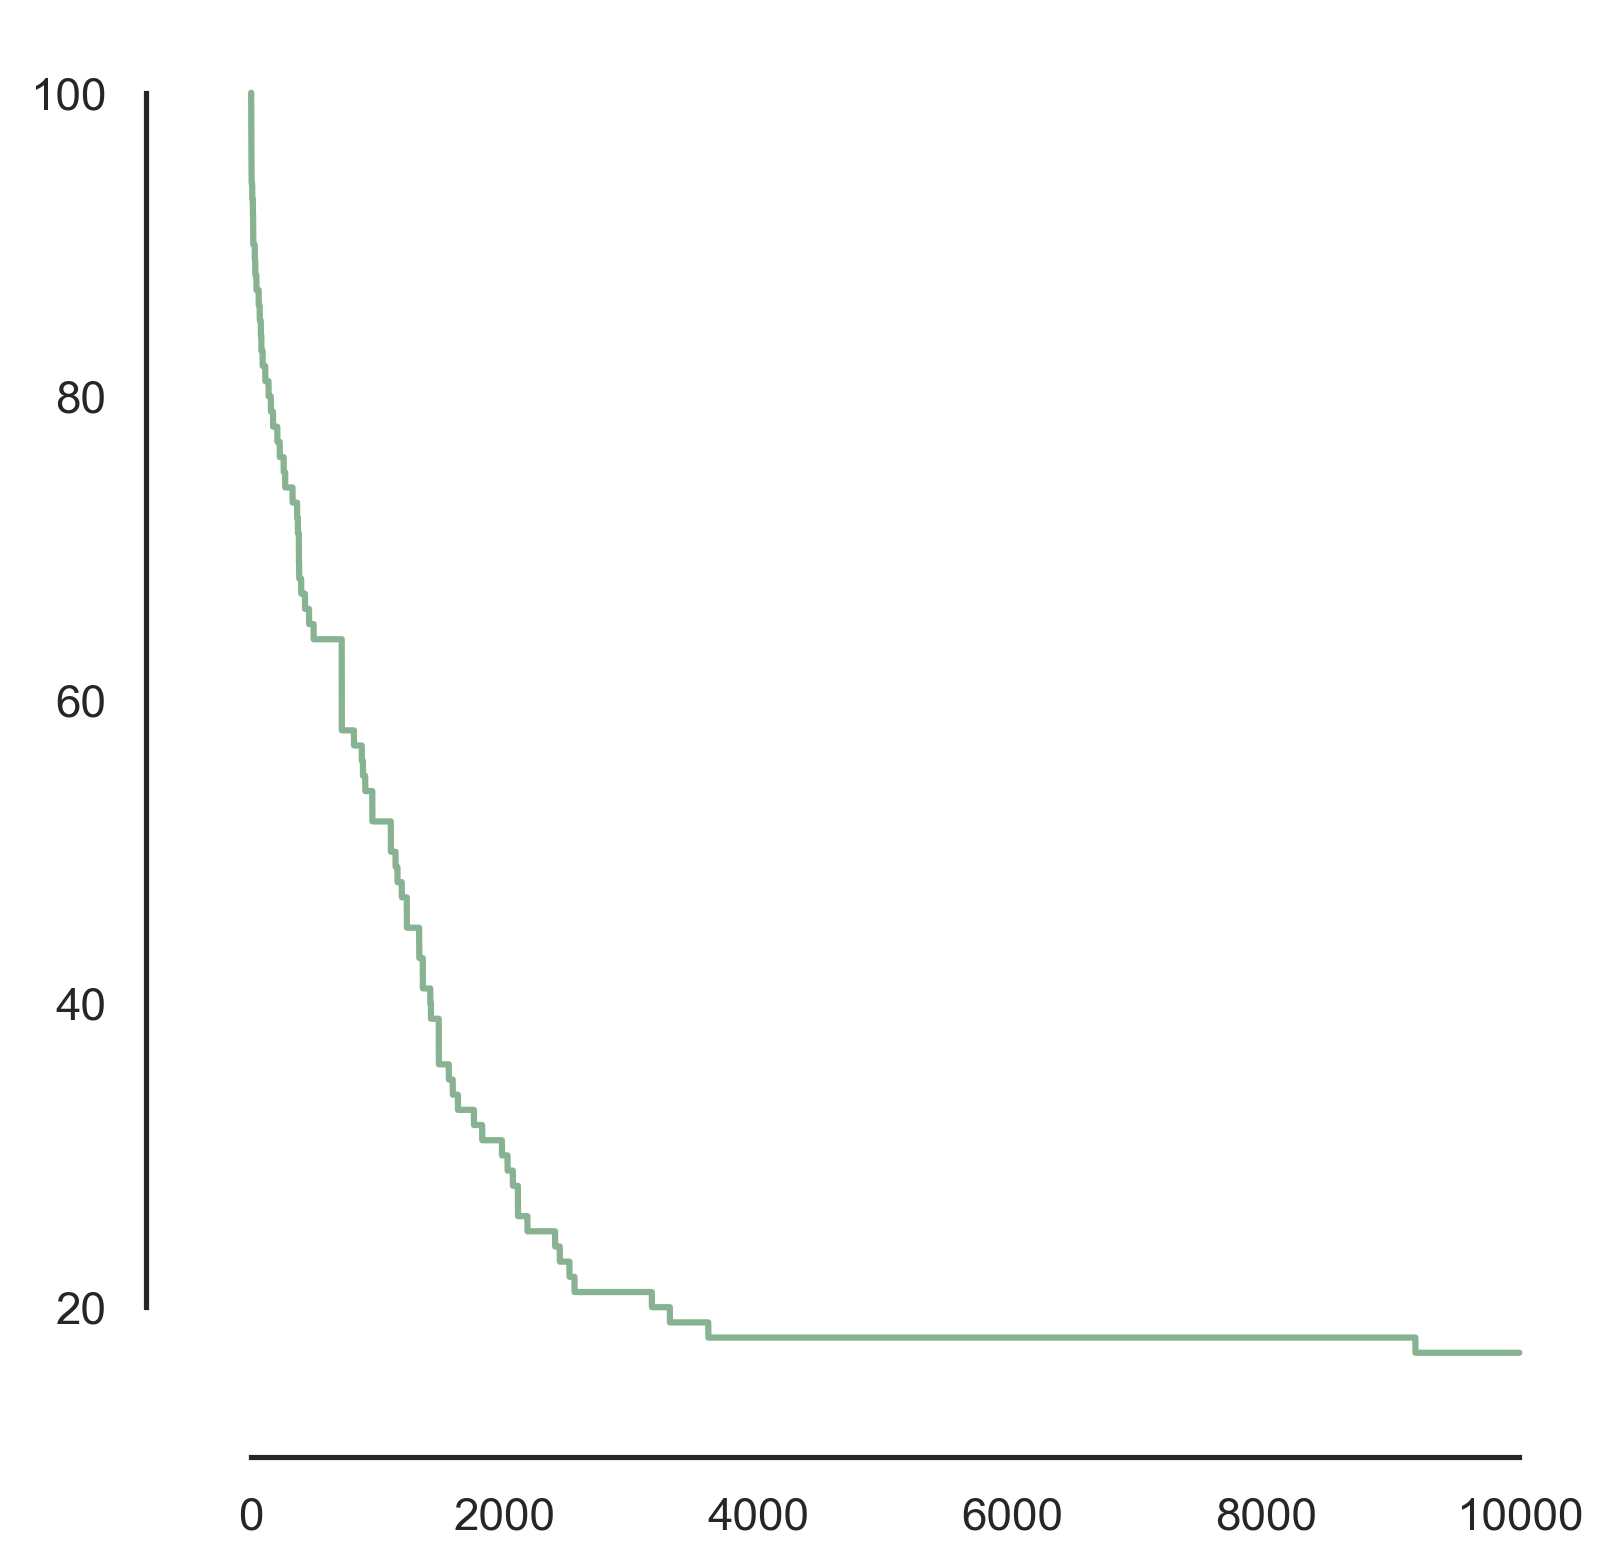

In [268]:
sns.set_style('white')
sns.lineplot(x=time, y=species_sorting, color='#88b392')
sns.despine(offset=10, trim=True)

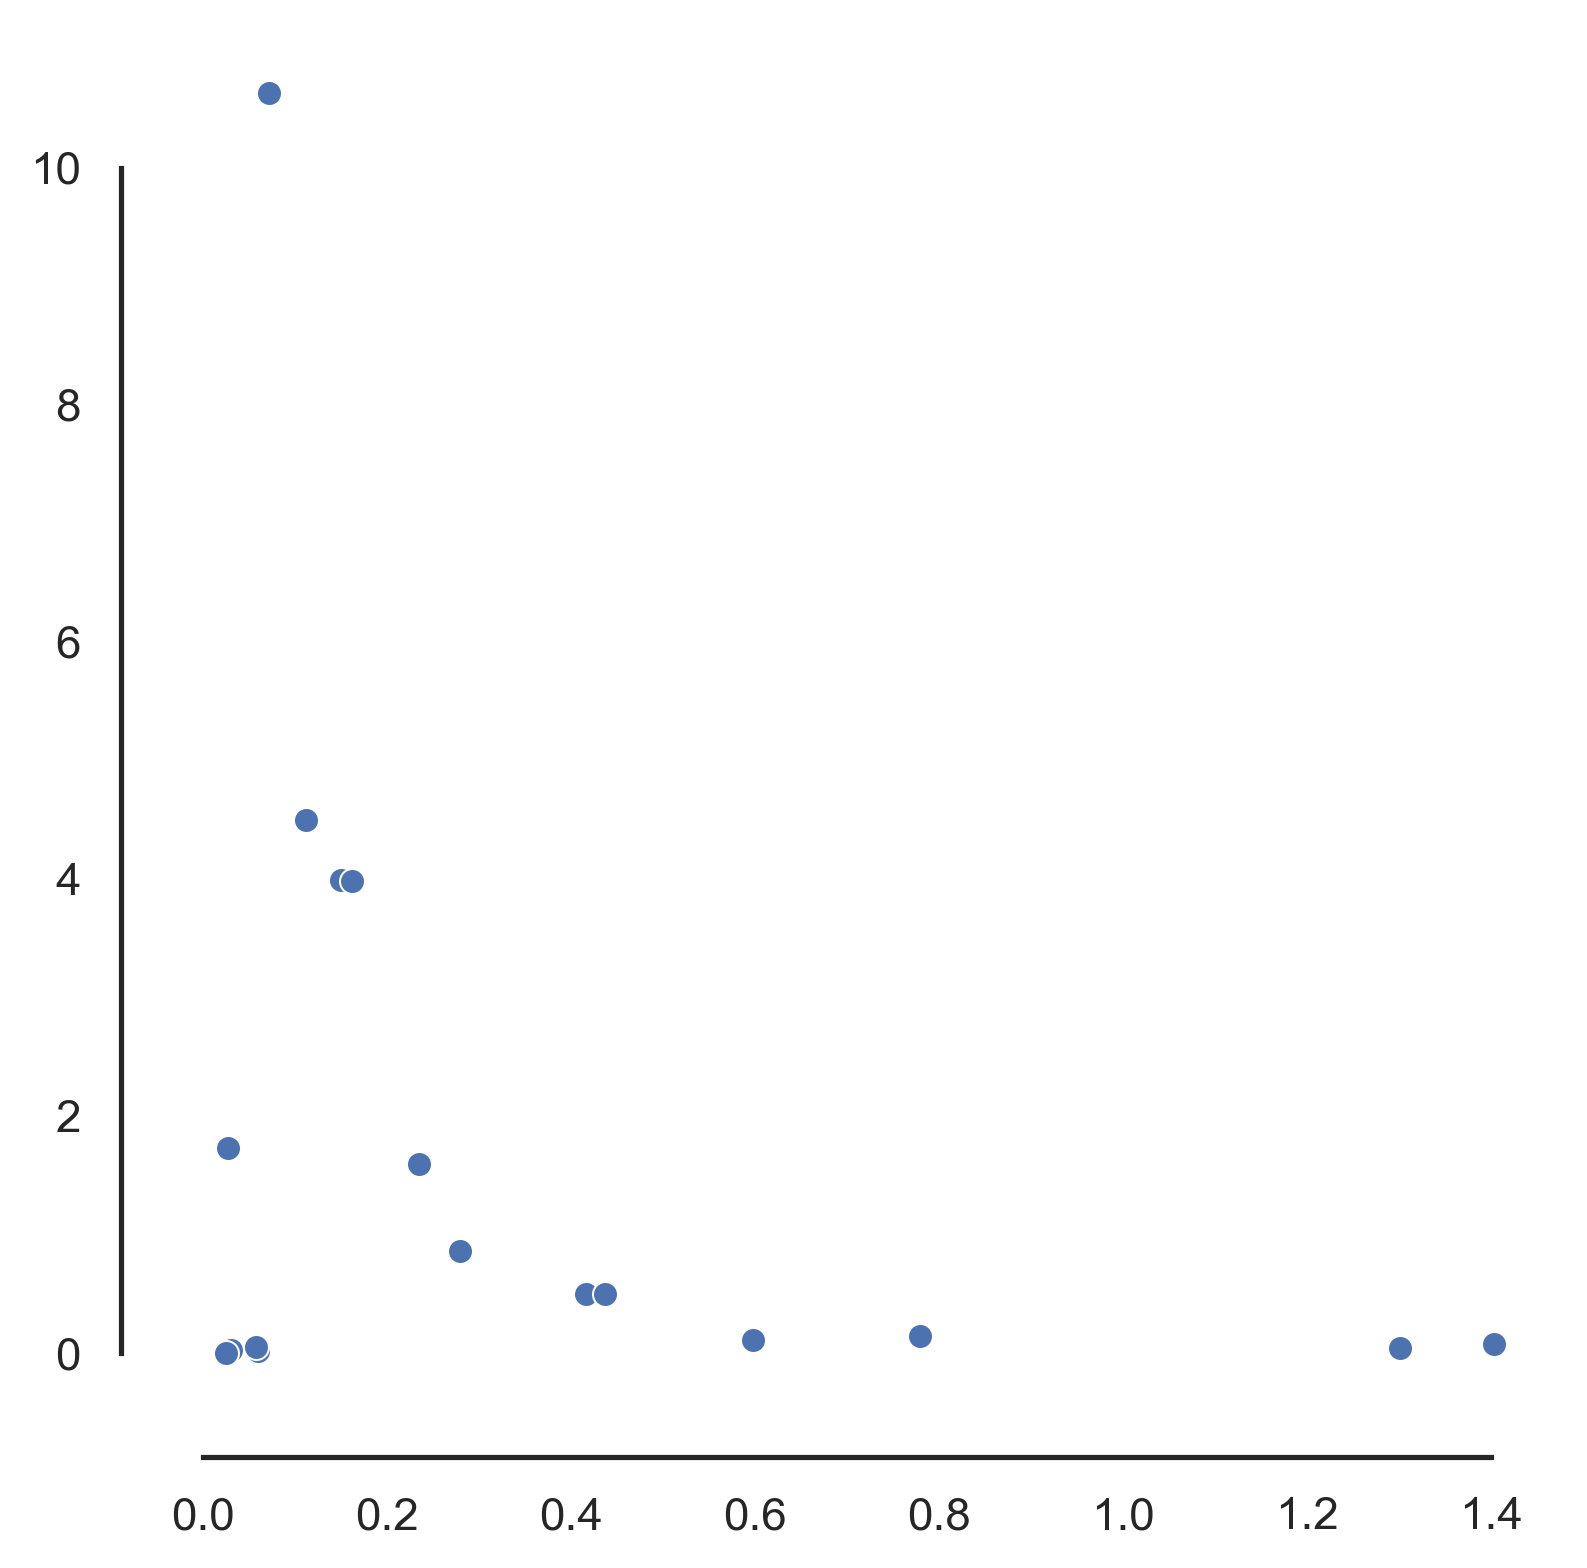

In [269]:
idx = np.where(repr_Ct[:, -1] > 0)[0]
oa = repr_Ct[idx, -1]
avgm_n = avgm[idx]
oa[oa>70] = 0
sns.set_style('white')
sns.scatterplot(x= avgm_n, y=oa)
sns.despine(offset=10, trim=True)


# Investigating the stability of Equilibrium state

### loading the data

In [577]:
base_dir = '..\Data'
sample_number = 1
type = '\eqAsb'
t_type = '_t.npy'
Para_type ='_Para.pkl'
Rt_type = '_Rt.npy'
Ct_type = '_Ct.npy'
id_type = '_ID.npy'
file_name = f'\eqAbl_{sample_number}'
t_asb = []
c_asb = []
r_asb = []
para_asb = []
id_asb = []

In [578]:
for i in range(1, 31):
    file_name = f'\eqAbl_{i}'
# start loading
    repr_t = np.load(base_dir + type + file_name + file_name + t_type)
    repr_Rt = np.load(base_dir + type + file_name + file_name + Rt_type)
    repr_Ct = np.load(base_dir + type + file_name + file_name + Ct_type)
    para = pkl.load(open(base_dir + type + file_name + file_name + Para_type, 'rb'))
    repr_id = np.load(base_dir + type + file_name + f'\Abl_{i}' + id_type)
    t_asb.append(repr_t)
    c_asb.append(repr_Ct)
    r_asb.append(repr_Rt)
    para_asb.append(para)
    id_asb.append(repr_id)

In [579]:
renum = 4
C = c_asb[renum]
t = t_asb[renum]
R = r_asb[renum]
para = para_asb[renum]
id = id_asb[renum]

In [580]:
ss = np.concatenate([C[:, -1].tolist(), R[:, -1].tolist()])

In [596]:
def jacobian(ss, para:Paras):
    
    # values and paras for calculating jacobian
    N, M, l, p, D = para.N, para.M, para.l, para.p, para.D
    vmax = para.v_in_max
    Rss = ss[N:N+M].reshape(M, 1)
    Css = ss[0:N].reshape(N, 1)
    v_in = vin(para.p, Rss, para.R_half, vmax)
    v_in = scale_vin(v_in, avgm, para.B0, para.alpha)
    v_grow = vgrow(v_in, para.l)
    v_out = vout(v_in, l, D)
    v_out = scale_vout(v_out, avgm, para.E0, para.gamma)
    nc = vmax*p*para.R_half

    # jacobian
    J = np.zeros((para.N+para.M, para.N+para.M))
    

    for n in range(para.N):
        # dfn/dCn
        J[n, n] = para.mu * (v_grow[n] - para.m[n])

        # dfn/dRm
        for m in range(para.M):
            J[n, m] = para.mu * Css[n] * (1-l[m]) * (nc[n, m]/(para.R_half + p[n, m]* Rss[m])**2)
    
    for m in range(para.M):
        # dfN+n/dRm
        J[N+m, m] = (D[m, m] - 1)*para.km*np.dot(Css.reshape(N, ), (nc[:, m]/((para.R_half + p[:, m]*Rss[m])**2)))

        for n in range(para.N):
            # dfN+n/dCn
            J[N+m, n] = para.km * Css[n]*(v_out[n, m]-v_in[n, m])
    
    eigval, eigvec = np.linalg.eig(J)
    # eigval = np.sort(np.real(eigval))

    return J, eigval, eigvec


In [597]:
J, eigval, eigvec = jacobian(ss, para)

In [634]:
np.linalg.det(J)

0.0

In [633]:
J.determinant()

AttributeError: 'numpy.ndarray' object has no attribute 'determinant'

# Creating intereaction network

In [428]:
para = pkl.load(open('..\Data\\variedC\w_1\w1_sAbl_1_Para.pkl', 'rb'))

In [533]:
def graph_dictL(para:Paras):

    N, M, P, D = para.N, para.M, para.p, para.D

    
    A = {}

    for n in range(1, N+1):
        
        id = np.where(D[n-1, :]>0)[0]
        A[f'C{n}'] = [f'R{m+1}' for m in id]

    for m in range(1, M+1):
        id = np.where(P[:, m-1]>0)[0]
        A[f'R{m}'] = [f'C{n+1}' for n in id]
    
    dG = nx.DiGraph(A)
    G = nx.Graph(A)
    return A, dG, G


In [534]:
D, dG, G = graph_dictL(para)


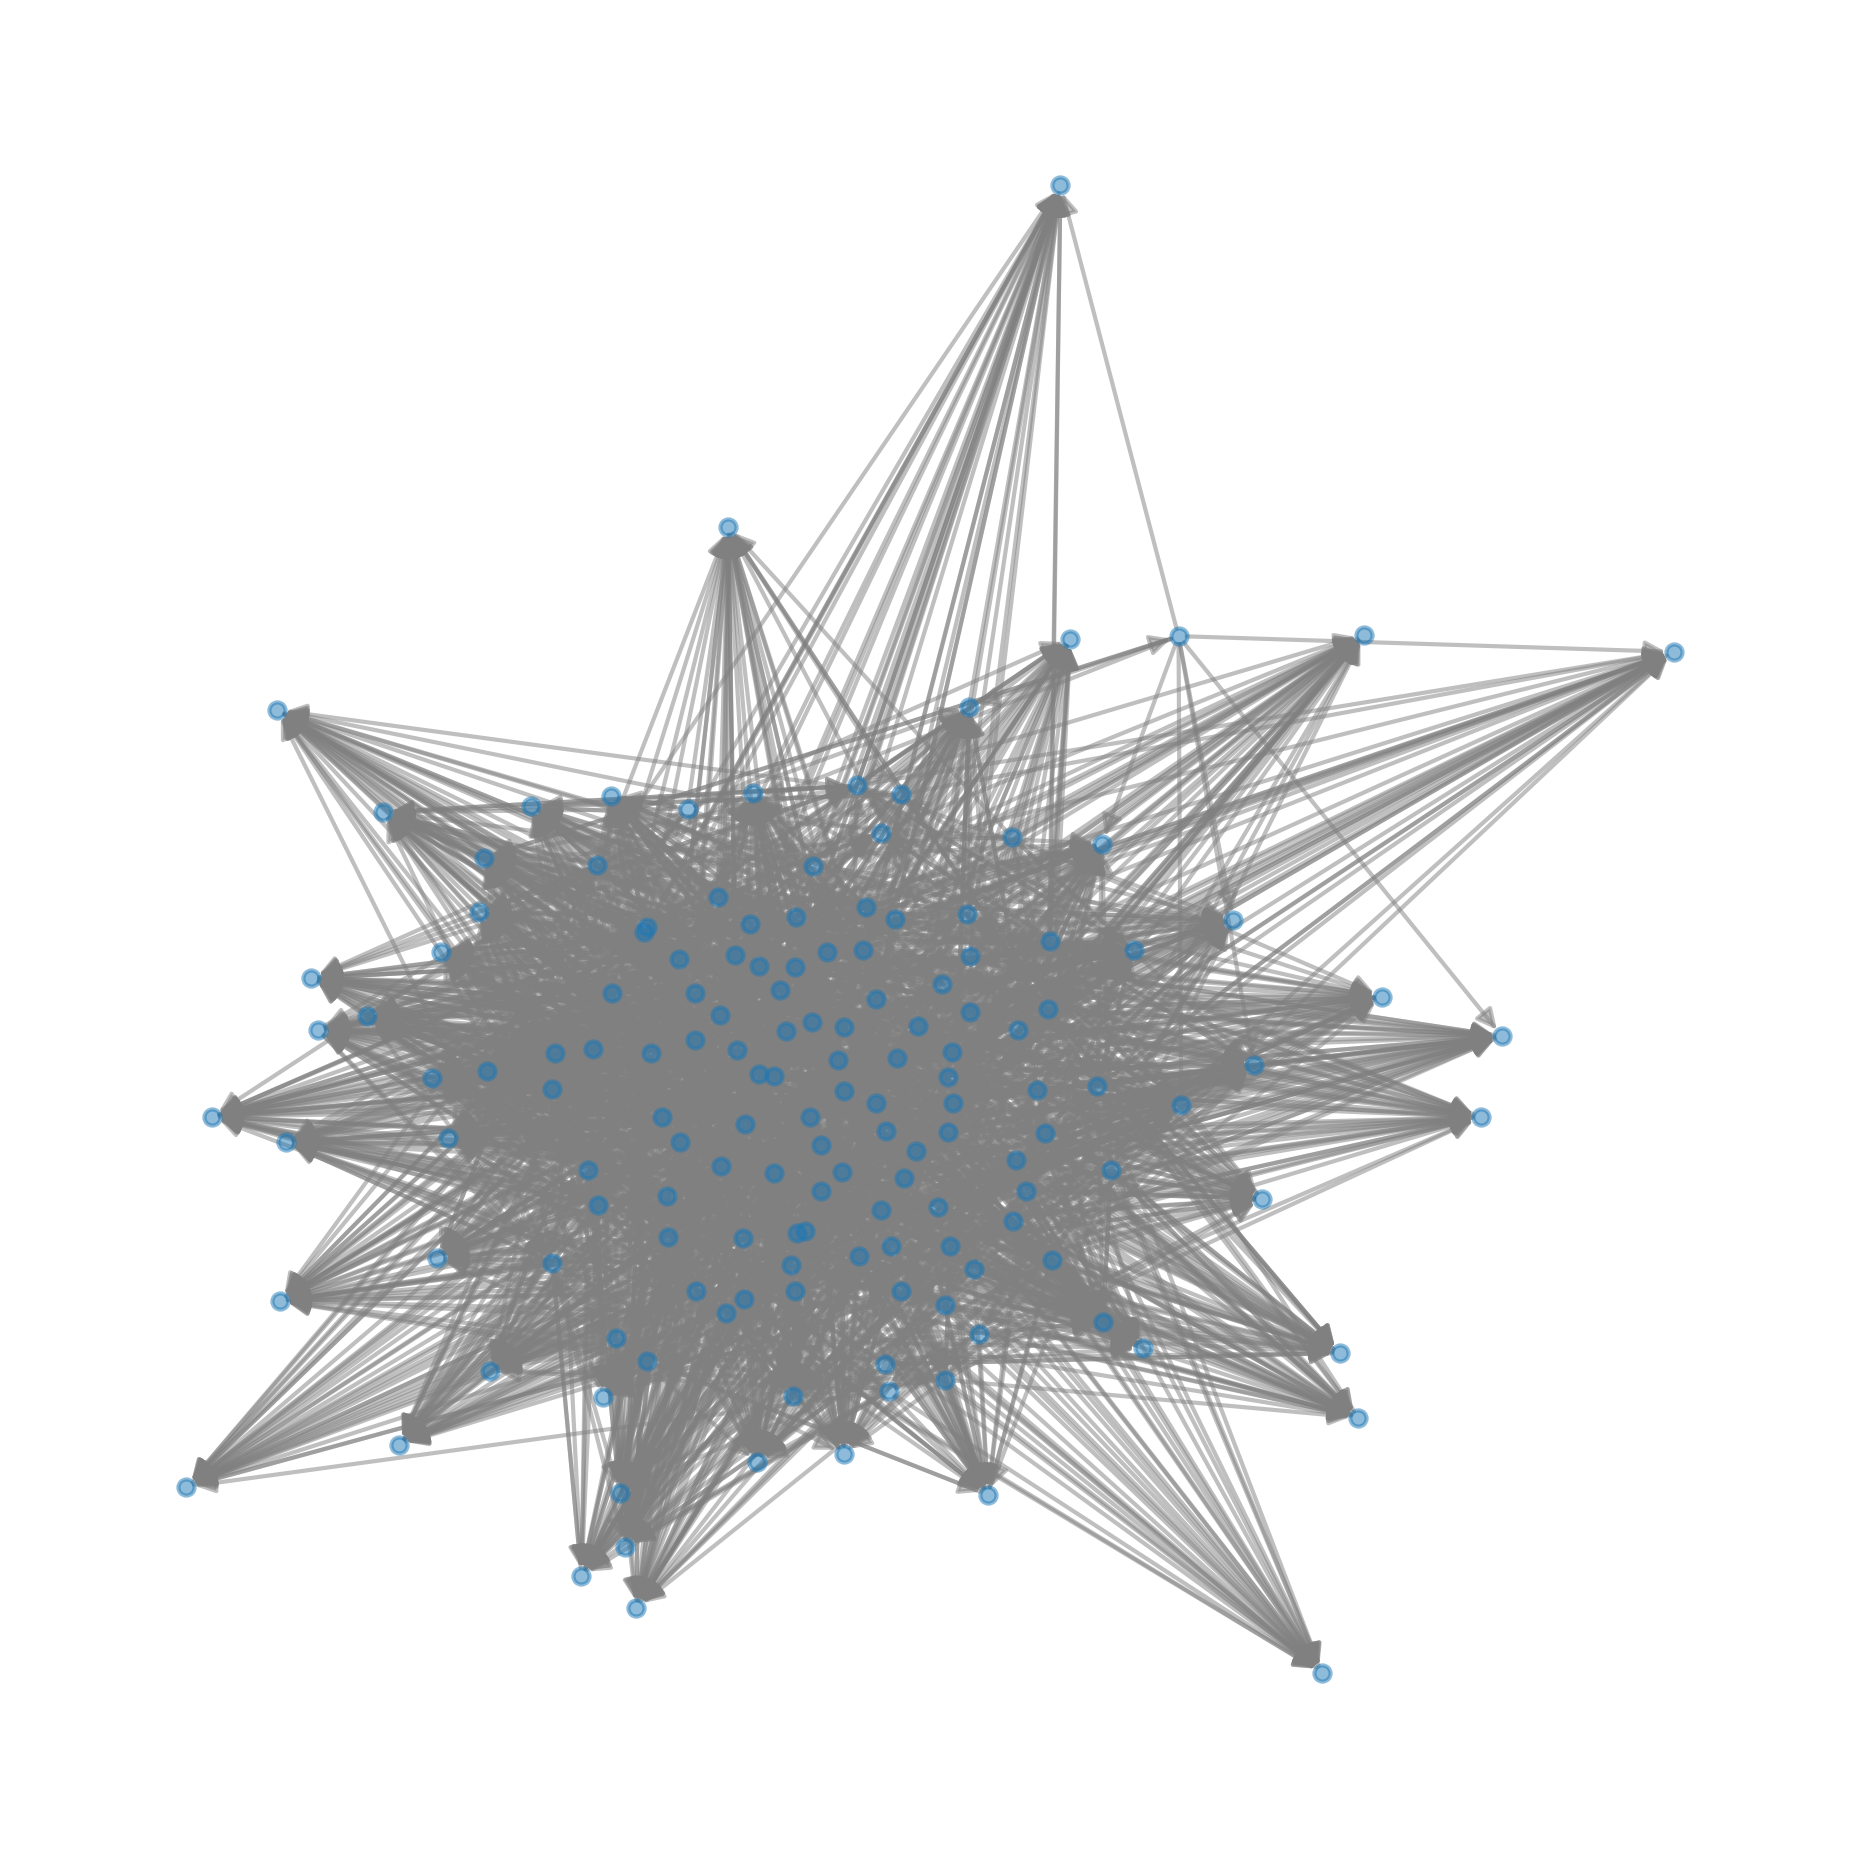

In [535]:
pos = nx.spring_layout(dG, seed=1448)
nx.draw(dG, pos=pos, node_size=15, edge_color='grey', alpha=0.5)

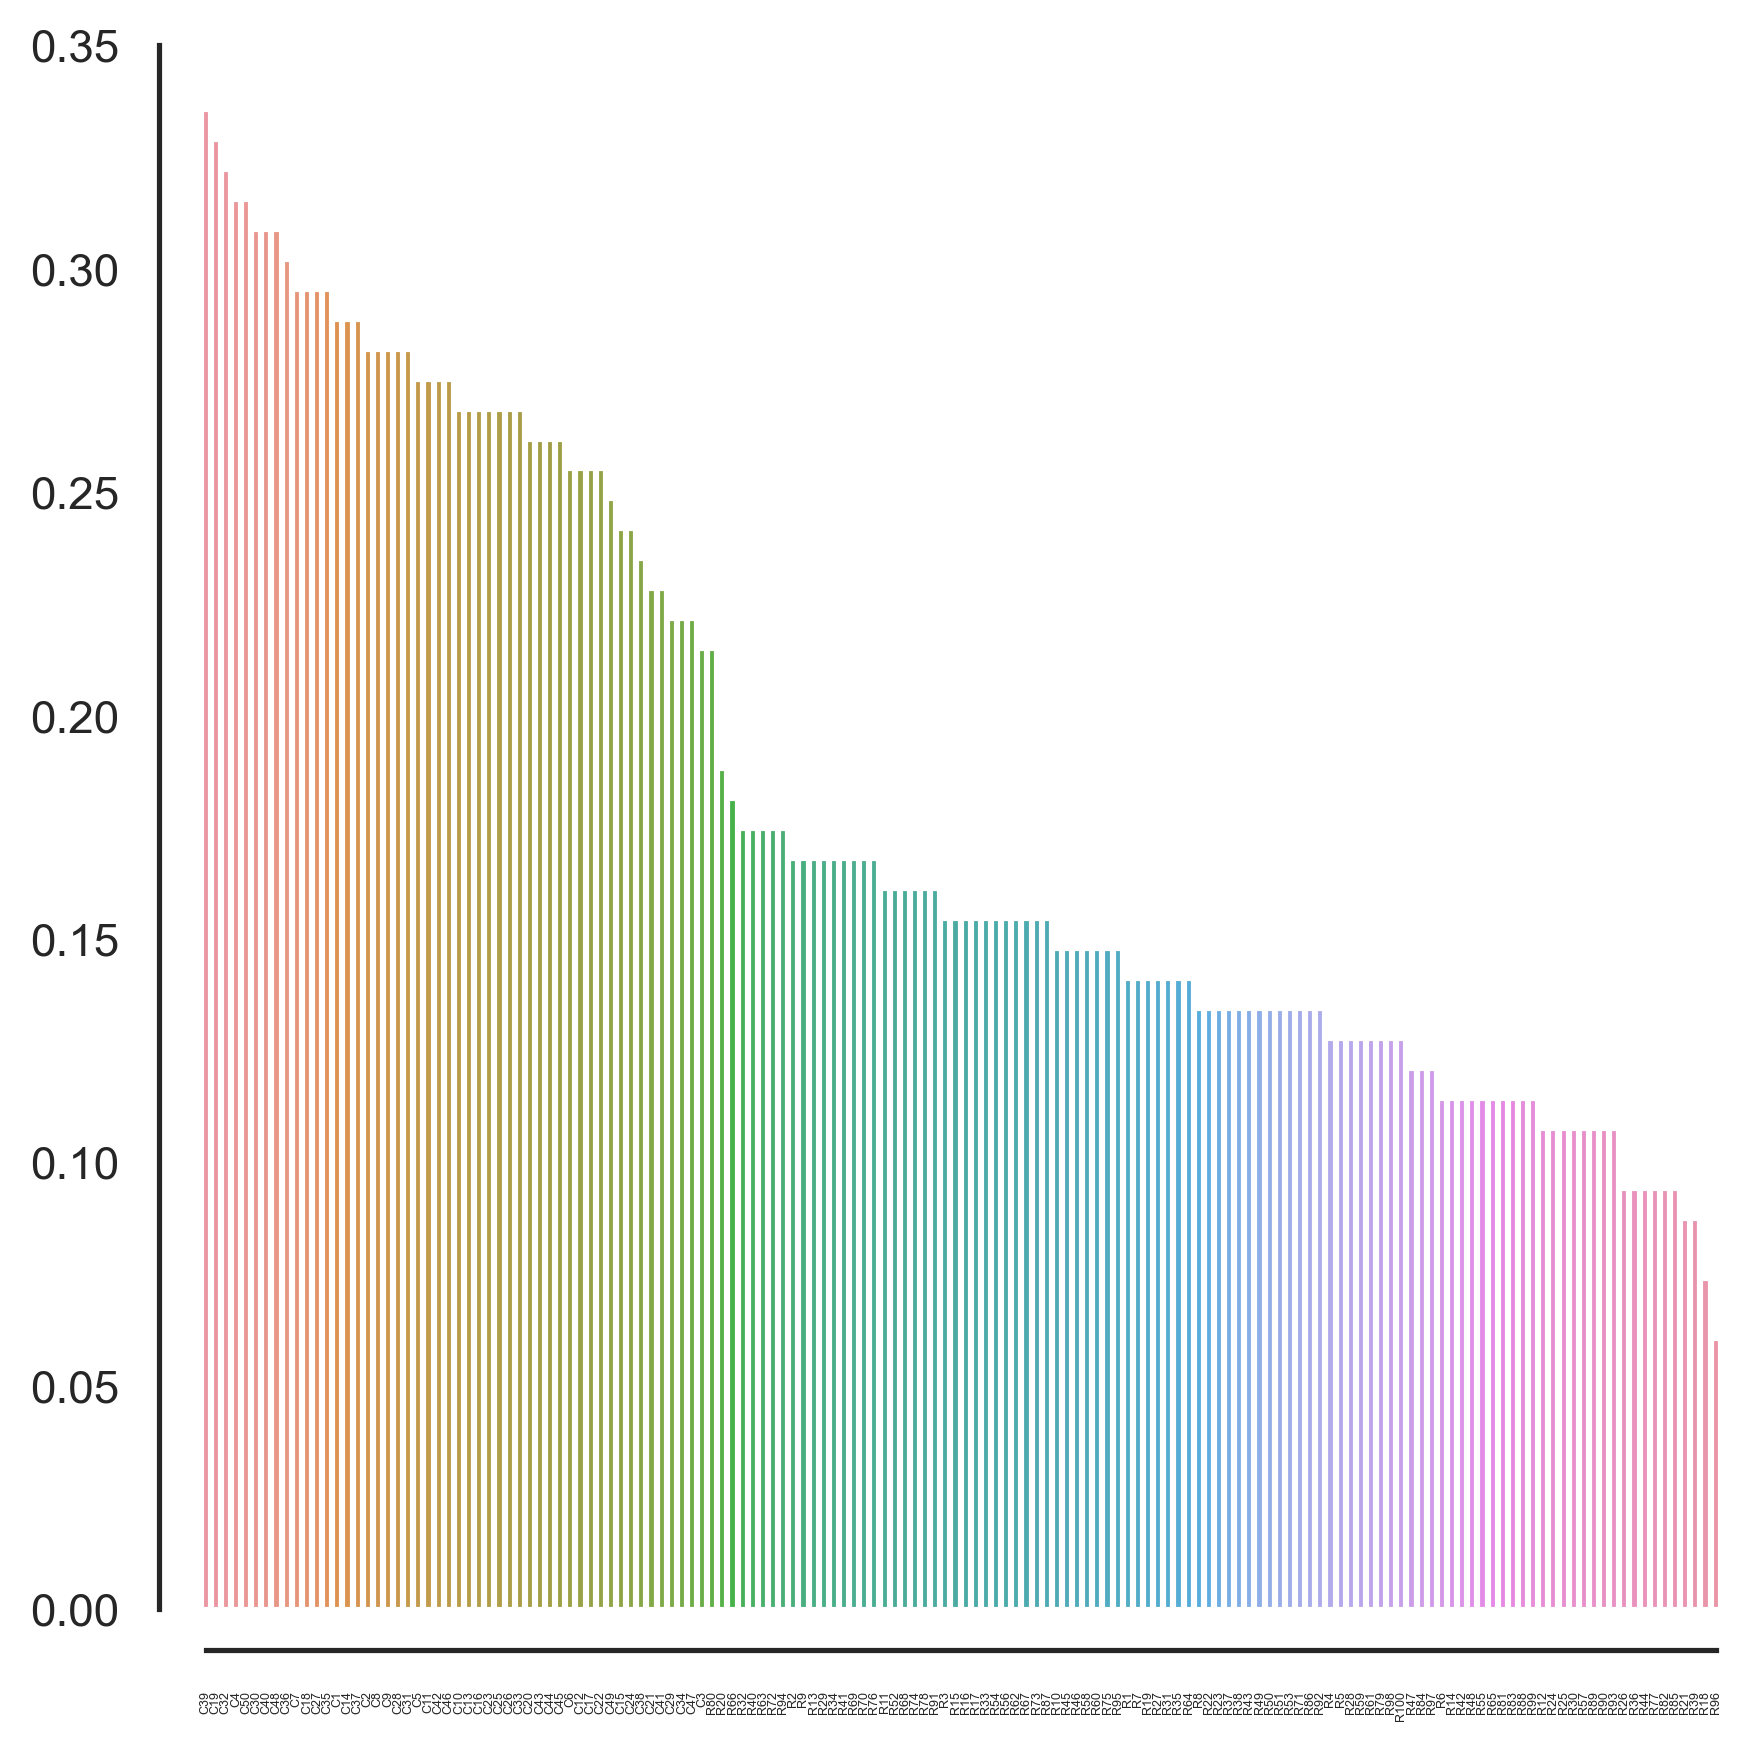

In [539]:
a = nx.degree_centrality(dG)
a = dict(sorted(a.items(), key=lambda a:a[1], reverse=True))
sns.barplot(x = list(a.keys()), y=list(a.values()))
sns.despine(trim=True, offset=10)
plt.xticks(rotation=90, fontsize=3)
plt.tight_layout()

In [561]:
d = list(a.items())
val = 1.
info = ''
for i in range(len(d)):
    if 'C' in d[i][0]:
        if d[i][1] < val:
            val = d[i][1]
            info = d[i][0]

In [604]:
bc = nx.betweenness_centrality(dG)
bc = dict(sorted(bc.items(), key=lambda bc:bc[1], reverse=True))

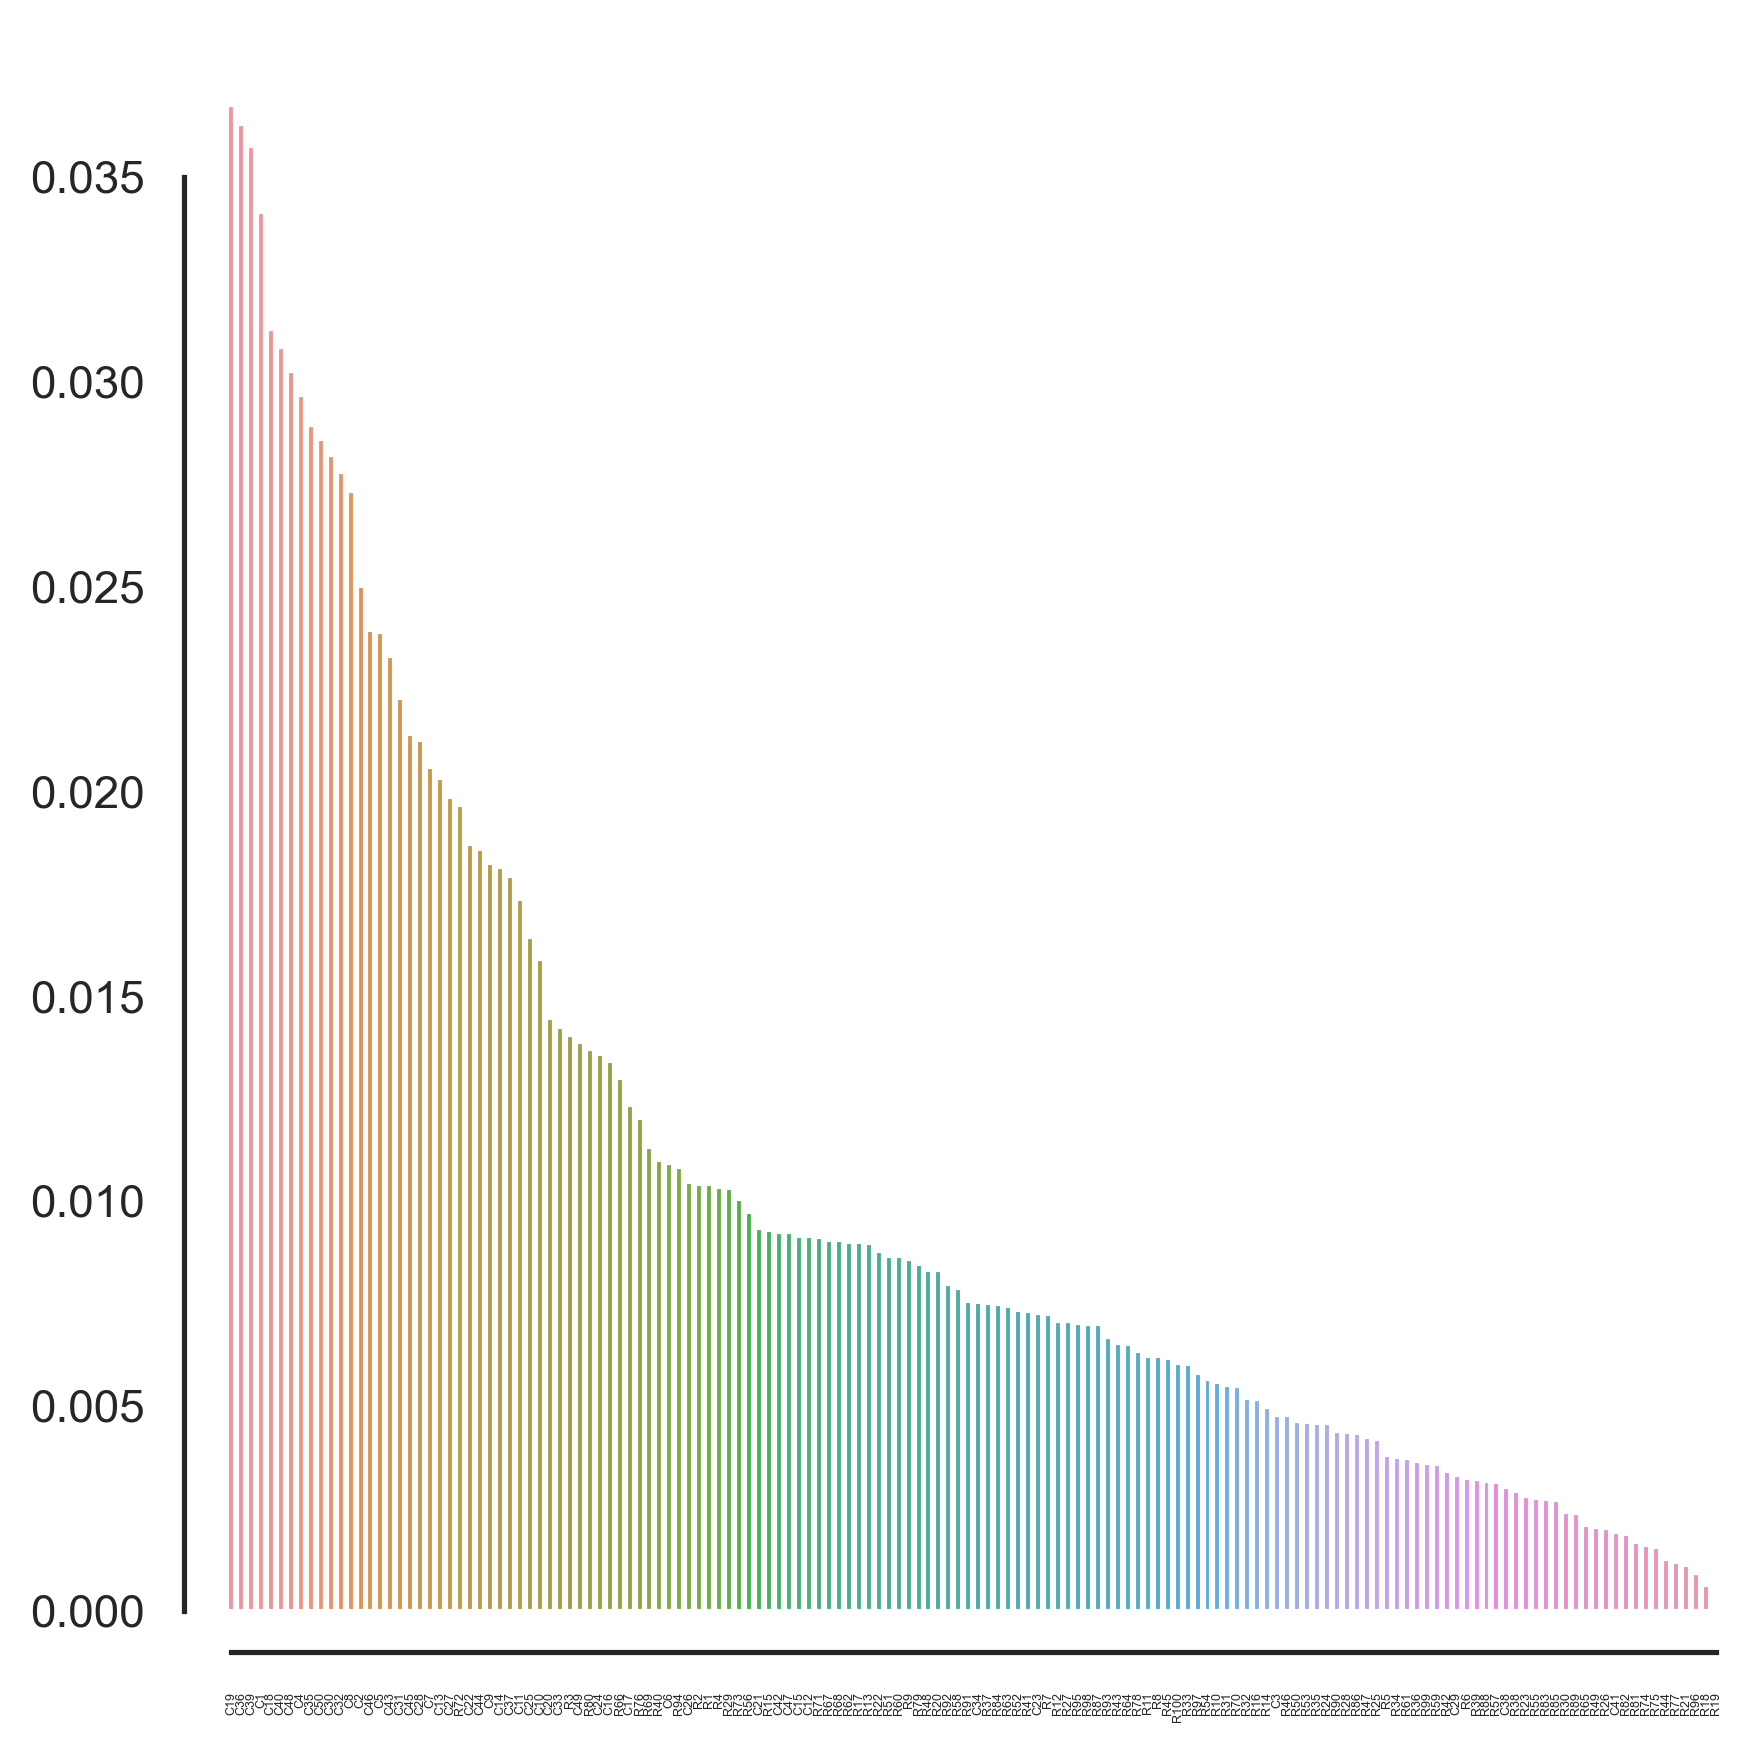

In [606]:
sns.barplot(x = list(bc.keys()), y=list(bc.values()))
sns.despine(trim=True, offset=10)
plt.xticks(rotation=90, fontsize=3)
plt.tight_layout()

In [613]:
iGidl = list(dG.in_degree)
Gid = {iGidl[i][0]:iGidl[i][1] for i in range(len(iGidl))}
Gid = dict(sorted(Gid.items(), key=lambda Gid:Gid[1], reverse=True))
x = list(Gid.keys())
y = list(Gid.values())

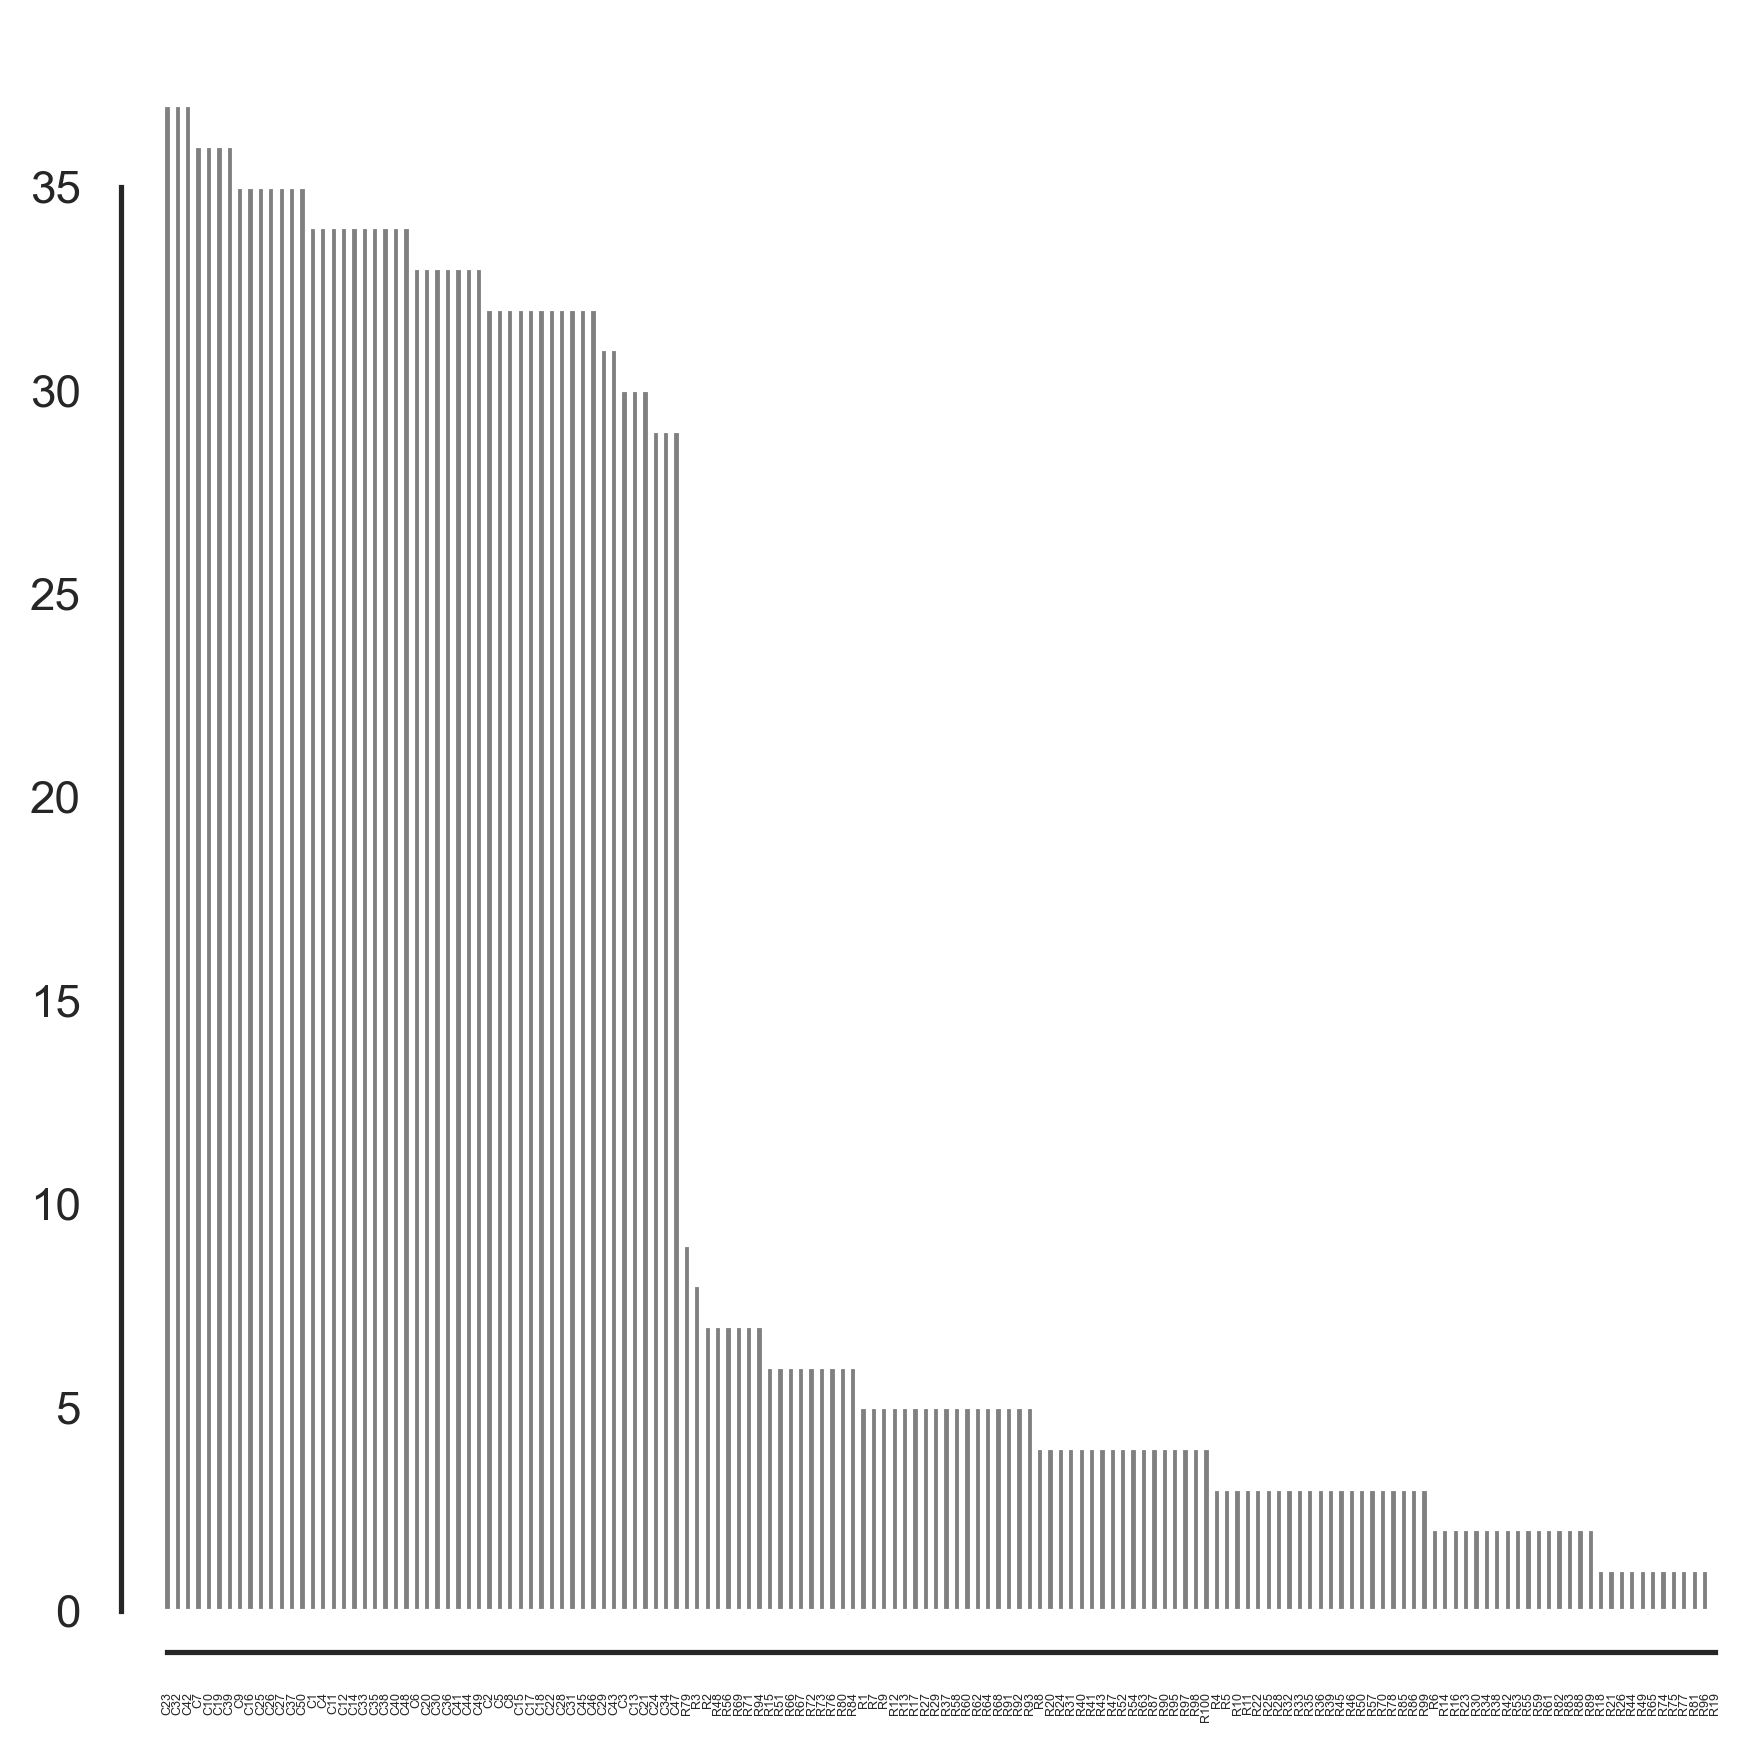

In [615]:
sns.barplot(x = x, y=y, color='grey')
sns.despine(trim=True, offset=10)
plt.xticks(rotation=90, fontsize=3)
plt.tight_layout()

In [621]:
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])